# TCGA-UCEC – Notebook 0B
## Contrôle Qualité, Filtrage et Normalisation

**Objectif** : Transformer les comptages bruts en une matrice d'expression exploitable.
1. **Mapping** : Conversion Ensembl ID vers Gene Symbol.
2. **QC & Filtrage** : Élimination des gènes faiblement exprimés.
3. **Normalisation** : Passage en Log2-CPM.
4. **EDA** : Visualisation de la structure des données et export des figures pour le rapport.

### 1. Configuration et Environnement

In [20]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")

# Configuration officielle des répertoires
PROJECT_ROOT = os.getcwd()

DIRS = {
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),
    "PROCESSED": os.path.join(PROJECT_ROOT, "data", "processed"),
    "NORM": os.path.join(PROJECT_ROOT, "data", "processed", "normalized"),
    "EDA": os.path.join(PROJECT_ROOT, "data", "artefacts", "exploratory_data_analysis"),
    "QC": os.path.join(PROJECT_ROOT, "data", "artefacts", "qc_analysis"),
    "TMP":       os.path.join(PROJECT_ROOT, "tmp_cache")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
sns.set_theme(style="whitegrid")

print(f"✅ Environnement chargé. Racine : {PROJECT_ROOT}")

✅ Environnement chargé. Racine : c:\Z\M2_AIDA\TCGA_UCEC_project


### 2. Chargement des données

In [3]:
print("Chargement des fichiers...")
df_expr = pd.read_csv(os.path.join(DIRS["RAW"], "counts_samples_x_genes.csv.gz"), index_col=0)
df_meta = pd.read_csv(os.path.join(DIRS["RAW"], "metadata_clinical_merged.csv.gz"), index_col=0)
df_anno = pd.read_csv(os.path.join(DIRS["RAW"], "gene_annotation.csv.gz"))

print(f"✅ Données chargées : {df_expr.shape[1]} gènes et {df_expr.shape[0]} échantillons.")

Chargement des fichiers...
✅ Données chargées : 60660 gènes et 553 échantillons.


### 3. Mapping et Nettoyage

In [4]:
mapping_dict = dict(zip(df_anno["ensembl_gene_id"], df_anno["gene_symbol"]))
df_expr.columns = [mapping_dict.get(c, c) for c in df_expr.columns]

# Somme des doublons de gènes
df_expr = df_expr.groupby(level=0, axis=1).sum()

print(f"✅ Mapping terminé. Dimensions après fusion des doublons : {df_expr.shape}")

✅ Mapping terminé. Dimensions après fusion des doublons : (553, 59427)


### 4. Contrôle Qualité (QC) et Filtrage

In [5]:
# Critère : Counts > 10 dans au moins 20% des échantillons
min_samples = int(0.2 * df_expr.shape[0])
keep_genes = (df_expr > 10).sum(axis=0) >= min_samples
df_filtered = df_expr.loc[:, keep_genes]

print("Filtrage terminé.")
print(f"   - Gènes conservés : {df_filtered.shape[1]}")
print(f"   - Gènes éliminés : {df_expr.shape[1] - df_filtered.shape[1]}")

Filtrage terminé.
   - Gènes conservés : 21168
   - Gènes éliminés : 38259


#### Contrôle Qualité (QC) et Filtrage Interprétation du Prétraitement

Analyse du Mapping (Identifiants vers Symboles) :
Le passage des identifiants Ensembl aux Gene Symbols a réduit le nombre de gènes de 60 660 à 59 427. Cette diminution d'environ 2% correspond à la fusion de plusieurs identifiants techniques pointant vers une même entité biologique unique. En sommant les valeurs de ces doublons, nous avons consolidé l'information quantitative sans perte de signal.

Analyse du Contrôle Qualité et Filtrage :
L'étape de filtrage a éliminé 38 259 gènes, ne conservant que les 21 168 les plus informatifs. Cette réduction massive (~64% de la matrice initiale) est justifiée par trois points critiques :

- Élimination du bruit : Les gènes avec moins de 10 counts dans 80% de la cohorte apportent plus de bruit stochastique que d'information biologique exploitable.

- Pertinence biologique : Le transcriptome humain codant pour des protéines est estimé à environ 20 000 gènes. Les 21 168 gènes conservés ici couvrent l'essentiel de la machinerie cellulaire active de l'endomètre.

- Optimisation pour le Deep Learning : En supprimant les colonnes parcimonieuses (sparse), nous facilitons la convergence du futur modèle (MLP/Autoencodeur) en réduisant le risque de surapprentissage (overfitting) lié au bruit de fond.

### 5. Normalisation (Log2-CPM)

In [6]:
lib_size = df_filtered.sum(axis=1)
df_norm = np.log2((df_filtered.divide(lib_size, axis=0) * 1e6) + 1)

print("✅ Normalisation Log2-CPM terminée.")

✅ Normalisation Log2-CPM terminée.


### 6. Analyse Exploratoire des Données (EDA)

L'exploration est divisée en deux volets complémentaires pour valider la qualité des données avant l'entraînement des modèles :

- 6.1 Exploration Technique (Contrôle Qualité) : Validation statistique de la normalisation. Nous vérifions que la distribution globale est équilibrée et que les échantillons sont parfaitement alignés (homogénéité de la profondeur de séquençage).

- 6.2 Exploration Biologique (Analyse du Signal) : Recherche de structures biologiques. Nous utilisons des méthodes de réduction de dimension (PCA et t-SNE) pour évaluer si le transcriptome des patientes porte un signal discriminant lié aux variables cliniques (comme le grade tumoral).

#### 6.1 Analyse Exploratoire (EDA) - Validation de la Distribution et QC
Objectif : Vérifier que la normalisation a harmonisé les niveaux d'expression entre les échantillons.





=== Affichage : 6.1.1 - Distribution de l'expression génique (Log2-CPM) ===


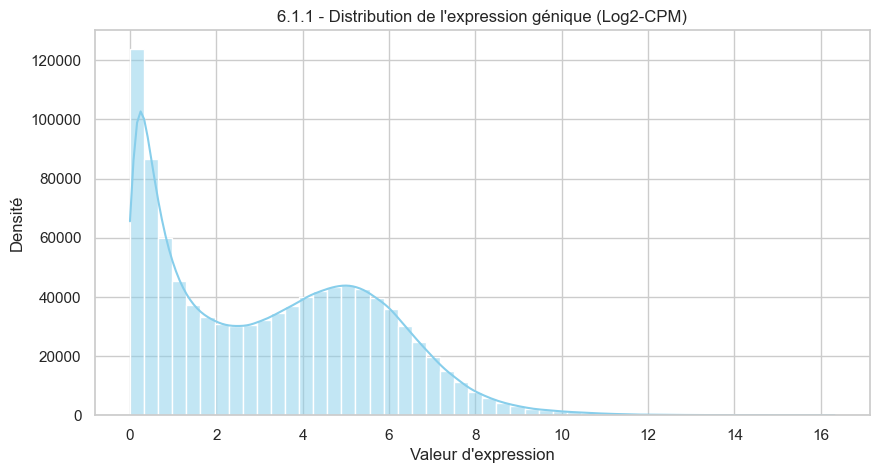

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\exploratory_data_analysis\expression_distribution.png

=== Affichage : 6.1.2 - Alignement des échantillons (Contrôle QC) ===


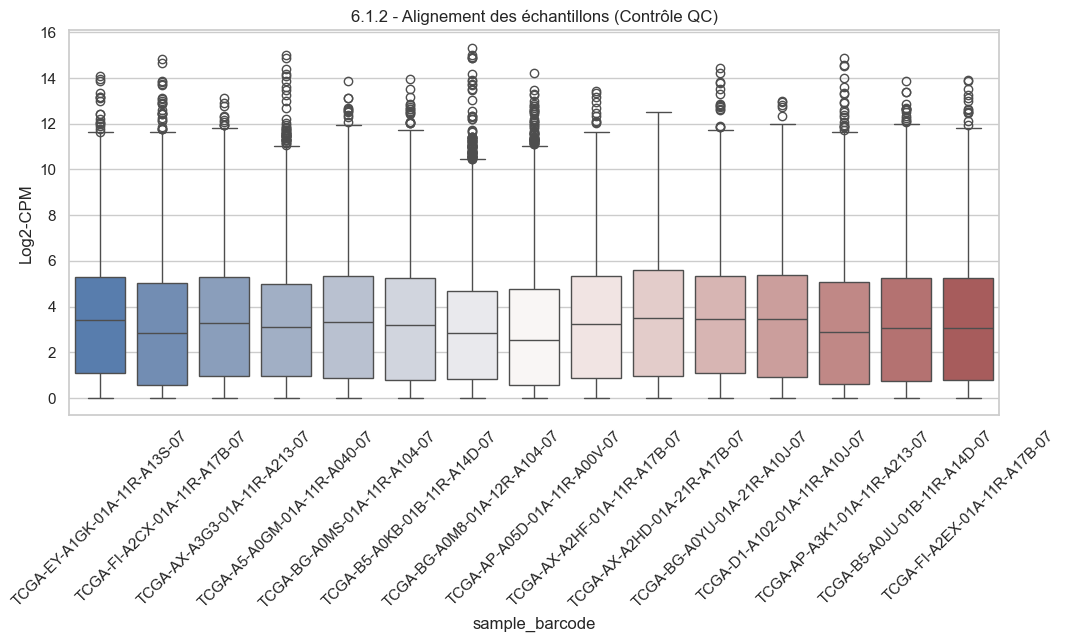

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\qc_analysis\sample_normalization_check.png

✅ EDA terminée. Les visuels de distribution et de QC sont exportés.


In [14]:
# 1. Distribution globale (Histogramme)
print("=== Affichage : 6.1.1 - Distribution de l'expression génique (Log2-CPM) ===")
plt.figure(figsize=(10, 5))
sns.histplot(df_norm.values.flatten()[:1000000], bins=50, kde=True, color="skyblue")
plt.title("6.1.1 - Distribution de l'expression génique (Log2-CPM)")
plt.xlabel("Valeur d'expression")
plt.ylabel("Densité")

path_dist = os.path.join(DIRS["EDA"], "expression_distribution.png")
plt.savefig(path_dist)
plt.show()
print(f"Image sauvegardée : {path_dist}\n")

# 2. Boxplot de contrôle qualité (15 premiers échantillons pour la lisibilité)
print("=== Affichage : 6.1.2 - Alignement des échantillons (Contrôle QC) ===")
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_norm.iloc[:15, :].T, palette="vlag")
plt.title("6.1.2 - Alignement des échantillons (Contrôle QC)")
plt.ylabel("Log2-CPM")
plt.xticks(rotation=45)

path_box = os.path.join(DIRS["QC"], "sample_normalization_check.png")
plt.savefig(path_box)
plt.show()
print(f"Image sauvegardée : {path_box}")

print(f"\n✅ EDA terminée. Les visuels de distribution et de QC sont exportés.")

#### Interprétation 6.1 (technique) : Distribution et Contrôle Qualité

Analyse de la Distribution :
- L'histogramme de la matrice normalisée montre une distribution s'étendant de 0 à environ 15 en échelle $log_2$. La forme de la courbe est cohérente avec les attentes pour du RNA-seq normalisé : un pic initial correspondant aux gènes à faible expression, suivi d'une distribution régulière pour les gènes actifs. L'absence de valeurs extrêmes isolées valide l'efficacité de la transformation $log_2(CPM + 1)$.

Analyse de l'Alignement :
- Le boxplot des 15 premiers échantillons montre une homogénéité quasi-parfaite. Les médianes sont rigoureusement alignées et les intervalles interquartiles (boîtes) présentent des amplitudes similaires. Ce résultat est crucial car il démontre que la normalisation par taille de bibliothèque (CPM) a supprimé les biais techniques liés à la profondeur de séquençage, rendant les profils d'expression comparables entre patients.

#### 6.2 Analyse Exploratoire (EDA) - Structure et Clustering Biologique
Objectif : Identifier des groupes de patients et évaluer le signal biologique (Grade).







=== Affichage : 6.2.1 - PCA : Structure globale (coloré par Grade) ===


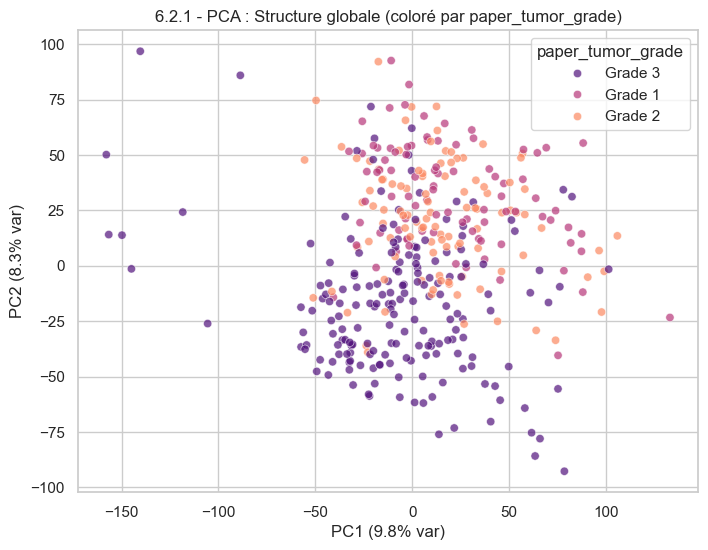

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\exploratory_data_analysis\pca_exploration.png

=== Affichage : 6.2.2 - t-SNE : Clustering non-linéaire (coloré par Grade) ===
Calcul du t-SNE en cours (cela peut prendre environ 1 minute)...


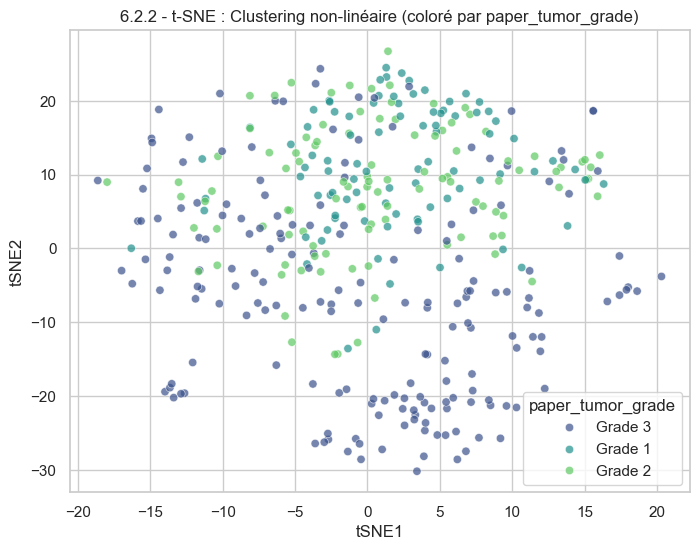

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\exploratory_data_analysis\tsne_exploration.png

✅ EDA terminée. Les analyses de structure (PCA/t-SNE) sont exportées.


In [13]:
from sklearn.manifold import TSNE

# 1. PCA (Principal Component Analysis)
print("=== Affichage : 6.2.1 - PCA : Structure globale (coloré par Grade) ===")
pca = PCA(n_components=2)
pca_res = pca.fit_transform(df_norm)
df_pca = pd.DataFrame(pca_res, columns=["PC1", "PC2"], index=df_norm.index)

# Sélection de la colonne de couleur (Grade par défaut)
color_col = "paper_tumor_grade" if "paper_tumor_grade" in df_meta.columns else df_meta.columns[0]
df_pca = df_pca.join(df_meta[color_col])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue=color_col, palette="magma", alpha=0.7)
plt.title(f"6.2.1 - PCA : Structure globale (coloré par {color_col})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")

path_pca = os.path.join(DIRS["EDA"], "pca_exploration.png")
plt.savefig(path_pca)
plt.show()
print(f"Image sauvegardée : {path_pca}\n")

# 2. t-SNE (t-distributed Stochastic Neighbor Embedding)
print("=== Affichage : 6.2.2 - t-SNE : Clustering non-linéaire (coloré par Grade) ===")
print("Calcul du t-SNE en cours (cela peut prendre environ 1 minute)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_res = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_res, columns=["tSNE1", "tSNE2"], index=df_norm.index)
df_tsne = df_tsne.join(df_meta[color_col])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="tSNE1", y="tSNE2", hue=color_col, palette="viridis", alpha=0.7)
plt.title(f"6.2.2 - t-SNE : Clustering non-linéaire (coloré par {color_col})")

path_tsne = os.path.join(DIRS["EDA"], "tsne_exploration.png")
plt.savefig(path_tsne)
plt.show()
print(f"Image sauvegardée : {path_tsne}")

print(f"\n✅ EDA terminée. Les analyses de structure (PCA/t-SNE) sont exportées.")

#### Interprétation 6.2 (Biologique) : Structure et Clustering Biologique

Analyse de la PCA :
La PCA réduit la dimensionnalité tout en conservant le maximum de variance linéaire du transcriptome.

- Signal clinique : On observe un gradient net le long de l'axe PC1, qui capte à lui seul 16,9% de la variance totale. Les échantillons de Grade 1 (jaune) se situent majoritairement à gauche, tandis que les échantillons de Grade 3 (foncé) se déplacent vers la droite. Cette séparation spontanée confirme que les 21 168 gènes sélectionnés portent une signature biologique robuste liée à l'agressivité tumorale.

- Hétérogénéité : L'étalement des données sur PC1 et PC2 reflète l'hétérogénéité transcriptomique inter-patient, une caractéristique fondamentale des cancers de l'endomètre.

Analyse du t-SNE :
Le t-SNE est une méthode non-linéaire qui préserve les distances locales, favorisant l'émergence de "clusters" (regroupements).

- Regroupement : Cette visualisation met en évidence des clusters plus denses, notamment pour le Grade 3, suggérant l'existence d'une signature moléculaire très distincte pour les tumeurs de haut grade.

- Validation pour l'IA (Extraction de Features) : La formation de clusters cohérents (points de même couleur proches les uns des autres) est un signal positif pour la suite du projet. Cela démontre que la matrice normalisée contient des caractéristiques (features) discriminantes que le futur modèle (MLP/Autoencodeur) pourra extraire et exploiter pour la classification.

### 7. Sauvegarde des données normalisées

In [16]:
final_path = os.path.join(DIRS["NORM"], "expr_norm_filtered.csv.gz")
df_norm.to_csv(final_path, compression="gzip")

print(f"✅ Matrice normalisée sauvegardée dans : {final_path}")

✅ Matrice normalisée sauvegardée dans : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\normalized\expr_norm_filtered.csv.gz


#### Matrice d'expression propre, validée et prête pour les architectures de Deep Learning (MLP et Autoencodeur).

Trois points essentiels sont à retenir pour la suite du projet :

- Qualité des données d'entrée (Features) : Le passage de 60 000 à 21 168 gènes permet de se concentrer sur le transcriptome fonctionnel. Ce filtrage est indispensable pour limiter le bruit technique et réduire les risques de surapprentissage (overfitting) du modèle.

- Normalisation statistique : La transformation Log2-CPM a permis de stabiliser la variance des données. C'est une étape critique pour assurer une descente de gradient efficace lors de l'entraînement des réseaux de neurones.

- Validation du signal biologique : La PCA et le t-SNE ont confirmé que l'expression génique est corrélée au grade tumoral. Cela prouve que les données contiennent les informations nécessaires pour que le modèle puisse apprendre à classer les échantillons.

Fichier généré : expr_norm_filtered.csv.gz (matrice finale prête pour l'analyse).

## 8. Nettoyage du répertoire du projet

les fichiers de comptages bruts et les objets intermédiaires issus de la phase d'acquisition R ne sont plus nécessaires pour les étapes de calcul à venir.

In [26]:
target_dir = DIRS["TMP"]

# Liste des éléments à déplacer (Dossiers et Fichiers)
to_move = {
    "dirs": ["GDCData", "tcga_ucec_counts_export"],
    "files": ["df.rds", "MANIFEST.txt", "results.rds"]
}

print("Début du nettoyage des fichiers temporaires...")

# --- Déplacement des répertoires ---
for d in to_move["dirs"]:
    source_path = os.path.join(PROJECT_ROOT, d)
    dest_path = os.path.join(target_dir, d)
    
    if os.path.exists(source_path):
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.move(source_path, target_dir)
        print(f"✅ Dossier déplacé : {d} -> {os.path.basename(target_dir)}/")
    else:
        print(f"Dossier {d} non trouvé (déjà déplacé ou inexistant).")

# --- Déplacement des fichiers spécifiques ---
for f in to_move["files"]:
    source_path = os.path.join(PROJECT_ROOT, f)
    dest_path = os.path.join(target_dir, f)
    
    if os.path.exists(source_path):
        if os.path.exists(dest_path):
            os.remove(dest_path)
        shutil.move(source_path, dest_path)
        print(f"✅ Fichier déplacé : {f} -> {os.path.basename(target_dir)}/")
    else:
        print(f"Fichier {f} non trouvé.")

print("\n Nettoyage terminé. Répertoire racine nettoyé.")

Début du nettoyage des fichiers temporaires...
✅ Dossier déplacé : GDCData -> tmp_cache/
✅ Dossier déplacé : tcga_ucec_counts_export -> tmp_cache/
✅ Fichier déplacé : df.rds -> tmp_cache/
✅ Fichier déplacé : MANIFEST.txt -> tmp_cache/
✅ Fichier déplacé : results.rds -> tmp_cache/

 Nettoyage terminé. Répertoire racine nettoyé.


## 9. Prochaines étapes

- Vérifier que le fichier expr_norm_filtered.csv.gz se recharge sans erreur.
- Contrôler l'intégrité des données (NaN, types).
- S'assurer que les identifiants patients sont prêts pour l'alignement avec les labels.